Note: this notebook is set up to run with the env.yml containing the name 'polaris_datasets'

## Background
ADME@NCATS is a resource developed by NCATS to host in silico prediction models for various ADME (Absorption, Distribution, Metabolism and Excretion) properties. The resource serves as an important tool for the drug discovery community with potential uses in compound optimization and prioritization. The models were retrospectively validated on a subset of marketed drugs which resulted in very good accuracies.

Data that were used for developing the models are made publicly accessible by depositing them into PubChem database. In some instances, when complete data cannot be made public, a subset of the data are deposited into PubChem. Links to the PubChem assays can be found in the individual model pages. The users are highly encouraged to use these data for development and validation of QSAR models.

## Assay Information
Cytochrome P450 (CYP) enzymes are membrane-bound hemeproteins that play a key role in metabolism of drugs and xenobiotics. Assaying the effect of chemicals on CYP isozymes is useful to minimize the adverse drug reactions and toxicities in drug development process. Chemical compounds were tested for their effect on CYP enzyme activities by using P450-Glo (TM) screening systems (Promega Corporation, Madison, WI). These systems provide a luminescent method containing proluciferin substrates and are converted to luciferin products by CYP isozymes. The luciferin products formed are detected with a luciferin detection reagent, and the amount of light produced is proportional to CYP activity. P450-Glo (TM) CYP2D6 screening system (Catalog. No. V9890) was used to detect the compounds that interfere in CYP2D6 activity. The positive control compound used for CYP2D6 assay is quinidine (Sigma-Aldrich, St. Louis, MO).

## Description of readout:
- **PUBCHEM_ACTIVITY_OUTCOME**: Corresponds to PUBCHEM_ACTIVITY_SCORE. For all inactive compounds, PUBCHEM_ACTIVITY_SCORE is 0. For all active compounds, a score range was given for each curve class type given above. Active antagonist compounds have PUBCHEM_ACTIVITY_SCORE between 40 and 100. Inconclusive compounds had PUBCHEM_ACTIVITY_SCORE between 1 and 39, and were removed in processing. 
- **PUBCHEM_ACTIVITY_SCORE**: Average of 5 experimental replicates. Fit_LogAC50 was used for determining relative score and was scaled to each curve class' score range.

## Data resource

**Raw data**: 
- CYP2D6: https://pubchem.ncbi.nlm.nih.gov/bioassay/1645840
- CYP3A4: https://pubchem.ncbi.nlm.nih.gov/bioassay/1645841
- CYP2C9: https://pubchem.ncbi.nlm.nih.gov/bioassay/1645842

In [4]:
%load_ext autoreload
%autoreload 2
import os
import pathlib
import warnings
import pandas as pd
import datamol as dm
import numpy as np

from sklearn.model_selection import ShuffleSplit
from polaris.cli import PolarisHubClient

# polaris curation module
from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID

# polaris dataset
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.dataset._column import Modality

# polaris benchmark
from polaris.benchmark import (
    SingleTaskBenchmarkSpecification,
    MultiTaskBenchmarkSpecification,
)
from polaris.utils.types import HubOwner

os.chdir(pathlib.Path("__file__").absolute().parents[1])

from utils import display_chemspace, load_readme, save_figure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# load data
data_train = pd.read_parquet(
    "gs://polaris-public/data/raw/novartis/surrogate_training_set_public.parquet"
)
data_train

,Structure,log_kobs,pIC50_CYP3A4,pIC50_CYP2C9,pIC50_CYP2D6,log_kobs_model_0,log_kobs_model_1,log_kobs_model_2,log_kobs_model_3,log_kobs_model_4,...,pIC50_CYP2D6_model_1,pIC50_CYP2D6_model_2,pIC50_CYP2D6_model_3,pIC50_CYP2D6_model_4,pIC50_CYP2D6_model_5,pIC50_CYP2D6_model_6,pIC50_CYP2D6_model_7,pIC50_CYP2D6_model_8,pIC50_CYP2D6_model_9,Source
0,CCCCc1nc2cc(/C=C/C(=O)NO)ccc2n1CCN(CC)CC.Cl.Cl,-2.131,4.957,4.733,4.823,-2.145,-1.988,-1.912,-2.347,-2.049,...,4.728,4.970,4.806,4.834,4.769,4.993,4.855,4.770,4.741,ChEMBL
1,CCCCc1ccc(N/C=N/O)cc1,-2.300,4.597,4.857,4.716,-2.345,-2.287,-2.399,-2.354,-2.209,...,4.737,4.684,4.614,4.852,4.603,4.737,4.732,4.694,4.901,ChEMBL
2,C[C@H](Nc1cc(-c2sc(C3CCN(C)CC3)nc2-c2ccc(F)cc2...,-1.940,4.740,4.686,4.883,-1.935,-1.995,-1.863,-2.123,-1.896,...,4.807,4.914,4.870,4.873,4.865,4.911,4.918,4.809,5.019,ChEMBL
3,CC(C)c1nc(-c2ccc(F)cc2)c(-c2ccc3nc(N)n(S(=O)(=...,-2.151,4.453,4.543,4.525,-2.220,-2.235,-2.149,-2.219,-2.112,...,4.497,4.470,4.533,4.547,4.578,4.443,4.625,4.477,4.492,ChEMBL
4,CC(C)S(=O)(=O)n1c(N)nc2ccc(-c3[nH]c(C(C)(C)C)n...,-2.283,4.372,4.432,4.463,-2.379,-2.294,-2.291,-2.323,-2.256,...,4.414,4.323,4.524,4.527,4.545,4.367,4.571,4.422,4.411,ChEMBL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16368,c1cc2c3c(c1)ccc1cccc(c13)C2,-1.773,5.450,4.925,5.054,-1.820,-1.939,-1.548,-1.693,-1.858,...,4.841,5.648,4.886,4.872,5.146,4.817,4.800,4.986,5.085,PubChem AID 884
16369,CC(=O)OC1CC2C(C)(C)C(O)C=C[C@@]2(C)C2CC[C@@]3(...,-1.622,5.840,4.694,4.692,-1.842,-1.648,-1.376,-2.188,-1.422,...,4.695,4.786,4.726,4.694,4.622,4.638,4.781,4.760,4.640,PubChem AID 884
16370,COc1c(O)cc2c(-c3ccccc3)cc(=O)oc2c1OC,-1.989,4.727,5.082,4.697,-1.894,-1.986,-2.002,-2.020,-2.018,...,4.701,4.695,4.733,4.659,4.654,4.682,4.736,4.748,4.661,PubChem AID 884
16371,CCN(CC)CCOC(=O)C(Cc1cccc2ccccc12)CC1CCCO1.O=C(...,-2.248,4.704,4.719,4.730,-2.169,-2.237,-2.160,-2.305,-2.272,...,4.723,4.746,4.764,4.726,4.719,4.695,4.735,4.676,4.787,PubChem AID 884


If we look at the columns in this raw dataframe, we see there are a lot of columns that we don't need. We will focus only on necessary columns below.

In [31]:
print(data.columns)

columns_to_keep = [
    "Structure", "log_kobs", "pIC50_CYP3A4", "pIC50_CYP2C9", "pIC50_CYP2D6"
]
data_train = data_train[columns_to_keep].copy()

# Rename columns
data_train = data_train.rename(
    columns={
        "Structure": "SMILES",
    }
)

Index(['SMILES', 'log_kobs', 'pIC50_CYP3A4', 'pIC50_CYP2C9', 'pIC50_CYP2D6'], dtype='object')


In [32]:
# Map the trehsholds
data_train["log_kobs"]

In [12]:
# Define data column names
data_cols = [ "log_kobs", "pIC50_CYP3A4", "pIC50_CYP2C9", "pIC50_CYP2D6"]
mol_col = "SMILES"

In [18]:
# Check the smiles 
data[data[mol_col].isna()]

,SMILES,log_kobs,pIC50_CYP3A4,pIC50_CYP2C9,pIC50_CYP2D6
14349,None,-2.087,4.684,4.807,4.836


In [23]:
# remove the rows wiht empty structure
data = data.dropna(subset=mol_col)
data.shape

(16372, 5)

### Run preliminary curation for data inspection

In [50]:
# preliminary curation for data inspection
curator = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    # data_types=["continuous"]*4,
    class_thresholds={"log_kobs": {"thresholds": [np.log10(0.01), np.log10(0.025)], "label_order": "ascending"}},
    mol_col=mol_col,
    mask_stereo_undefined_mols=False,
    keep_all_rows=True,
)
data_look = curator()

2024-04-22 13:18:49.862 | WARNING  | polaris.curation._data_curator:run_data_curation:233 - Data types are not provides. We will try our best to determine the types
2024-04-22 13:18:49.865 | WARNING  | polaris.curation._data_curator:check_outliers:201 - Detected 10 outliers for data column log_kobs using zscore. Please revise the data and consider remove the outliers. 
2024-04-22 13:18:49.866 | WARNING  | polaris.curation._data_curator:check_outliers:201 - Detected 141 outliers for data column pIC50_CYP3A4 using zscore. Please revise the data and consider remove the outliers. 
2024-04-22 13:18:49.868 | WARNING  | polaris.curation._data_curator:check_outliers:201 - Detected 337 outliers for data column pIC50_CYP2C9 using zscore. Please revise the data and consider remove the outliers. 
2024-04-22 13:18:49.870 | WARNING  | polaris.curation._data_curator:check_outliers:201 - Detected 508 outliers for data column pIC50_CYP2D6 using zscore. Please revise the data and consider remove the out

2024-04-22 13:18:56.152 | WARNING  | polaris.curation.viz_utils:detailed_distributions_plots:334 - Threshold not available for readout 'log_kobs'
2024-04-22 13:18:56.247 | WARNING  | polaris.curation.viz_utils:detailed_distributions_plots:334 - Threshold not available for readout 'pIC50_CYP3A4'
2024-04-22 13:18:56.379 | WARNING  | polaris.curation.viz_utils:detailed_distributions_plots:334 - Threshold not available for readout 'pIC50_CYP2C9'
2024-04-22 13:18:56.498 | WARNING  | polaris.curation.viz_utils:detailed_distributions_plots:334 - Threshold not available for readout 'pIC50_CYP2D6'


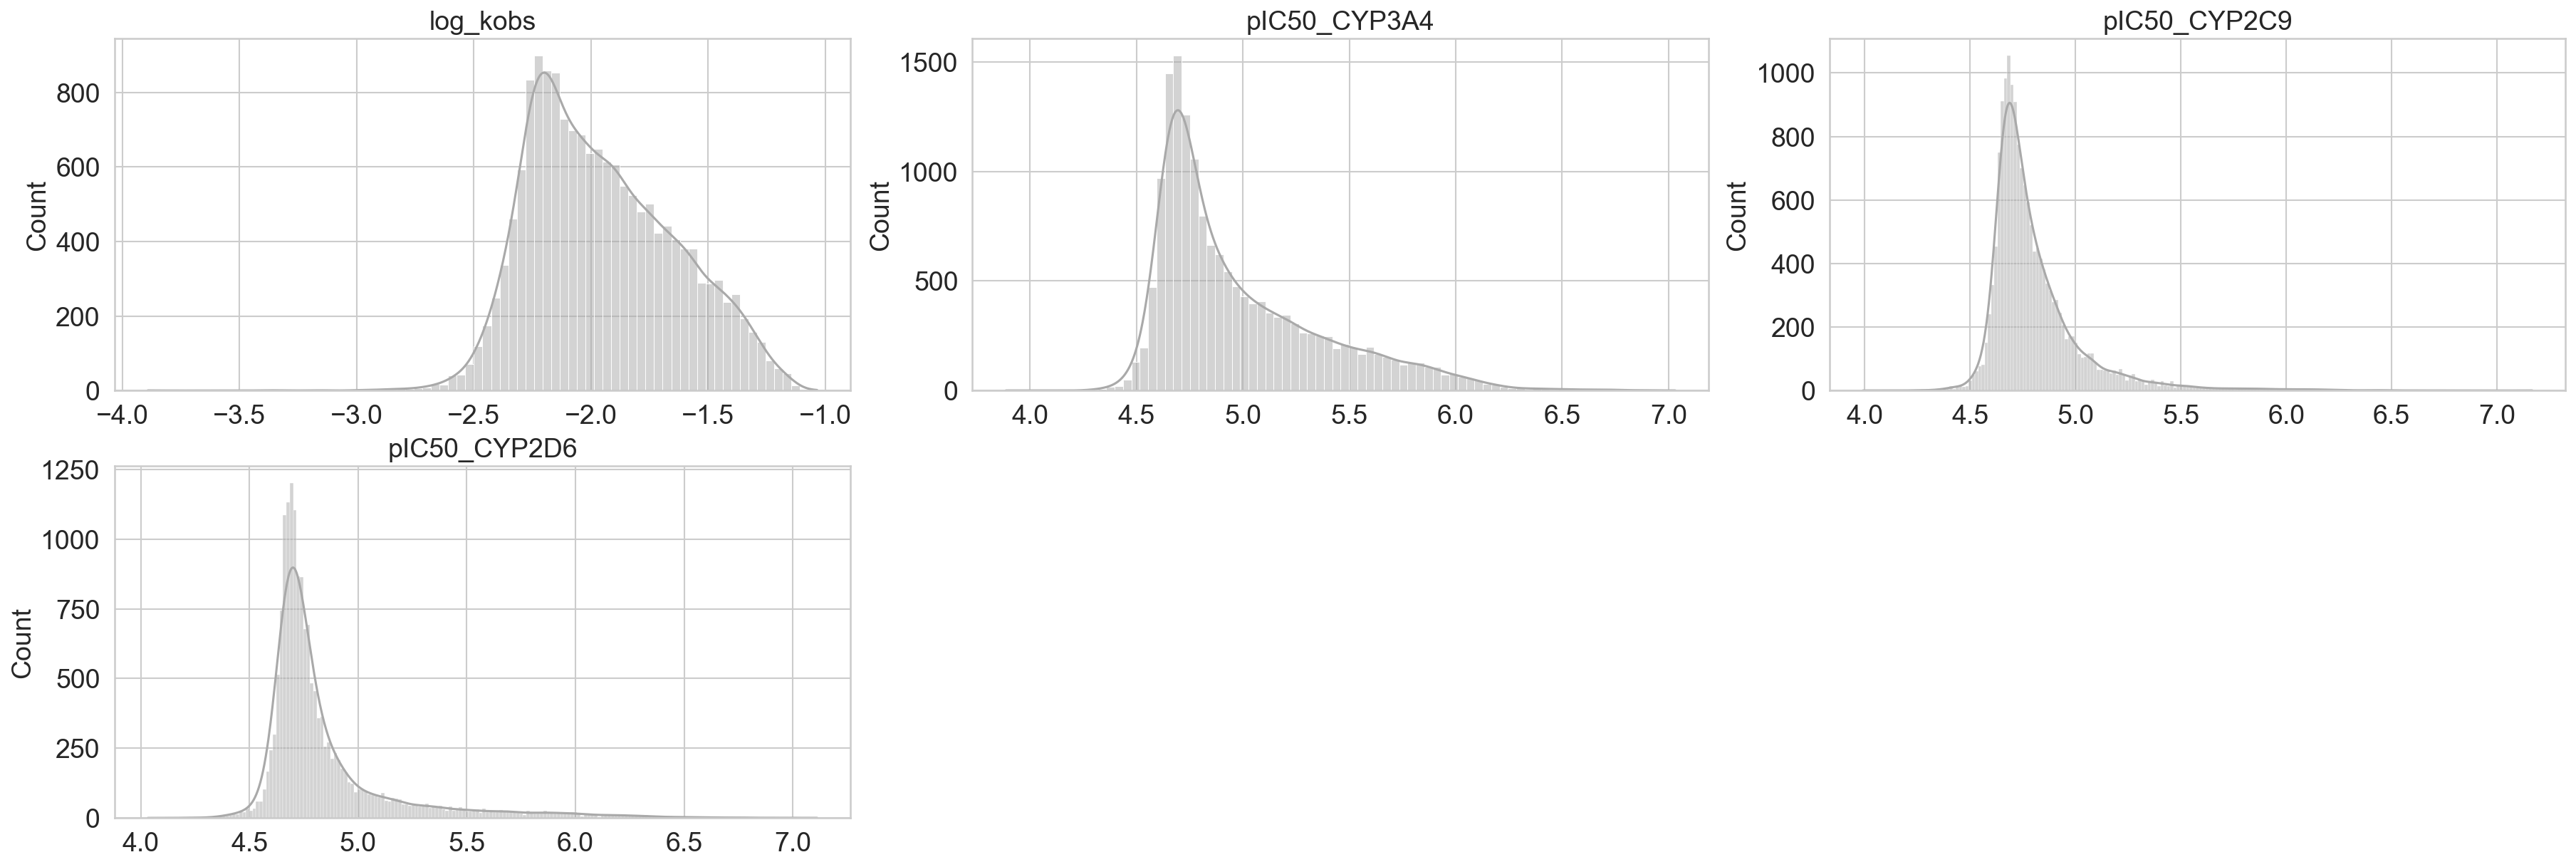

In [51]:
# Distribution plot of all related readouts
fig = detailed_distributions_plots(df=data_look[data_cols])

The curation detected 3 outliers in the data. Let's take a look at the distribution.

The flagged outliers are likely false outliers as they are located on the end of the data distribution.

### Check activity shift between stereoisomers

In [52]:
data_look.columns

Index(['SMILES', 'log_kobs', 'pIC50_CYP3A4', 'pIC50_CYP2C9', 'pIC50_CYP2D6',
       'ORIGINAL_log_kobs', 'ORIGINAL_pIC50_CYP3A4', 'ORIGINAL_pIC50_CYP2C9',
       'ORIGINAL_pIC50_CYP2D6', 'ORIGINAL_SMILES', 'smiles', 'molhash_id',
       'molhash_id_no_stereo', 'num_stereo_center',
       'num_undefined_stereo_center', 'num_defined_stereo_center',
       'num_stereoisomers', 'num_undefined_stereoisomers', 'undefined_E_D',
       'undefined_E/Z', 'OUTLIER_log_kobs', 'OUTLIER_pIC50_CYP3A4',
       'OUTLIER_pIC50_CYP2C9', 'OUTLIER_pIC50_CYP2D6', 'CLASS_log_kobs',
       'CLASS_log_kobs_stereo_cliff', 'pIC50_CYP3A4_zscore',
       'pIC50_CYP3A4_stereo_cliff', 'pIC50_CYP2C9_zscore',
       'pIC50_CYP2C9_stereo_cliff', 'pIC50_CYP2D6_zscore',
       'pIC50_CYP2D6_stereo_cliff'],
      dtype='object')

In [61]:
data_look.query("CLASS_log_kobs_stereo_cliff == True")

,SMILES,log_kobs,pIC50_CYP3A4,pIC50_CYP2C9,pIC50_CYP2D6,ORIGINAL_log_kobs,ORIGINAL_pIC50_CYP3A4,ORIGINAL_pIC50_CYP2C9,ORIGINAL_pIC50_CYP2D6,ORIGINAL_SMILES,...,OUTLIER_pIC50_CYP2C9,OUTLIER_pIC50_CYP2D6,CLASS_log_kobs,CLASS_log_kobs_stereo_cliff,pIC50_CYP3A4_zscore,pIC50_CYP3A4_stereo_cliff,pIC50_CYP2C9_zscore,pIC50_CYP2C9_stereo_cliff,pIC50_CYP2D6_zscore,pIC50_CYP2D6_stereo_cliff
54,CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...,-1.235,6.056,4.814,4.927,-1.235,6.056,4.814,4.927,CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...,...,False,False,2.0,True,4.343935,True,0.586165,True,1.646809,True
128,CN[C@H]1Cc2ccccc2[C@H](c2ccc(Cl)c(Cl)c2)C1,-2.020,4.688,4.631,5.942,-2.020,4.688,4.631,5.942,CN[C@H]1Cc2ccccc2[C@H](c2ccc(Cl)c(Cl)c2)C1,...,False,True,0.0,True,-0.551043,NaN,-0.883262,NaN,10.537823,True
144,CN(CC(=O)N1CCCC(c2ccccc2)C1CN1CCCC1)c1ccc(Cl)c...,-1.645,5.028,4.669,5.649,-1.645,5.028,4.669,5.649,CN(CC(=O)N1CCCC(c2ccccc2)C1CN1CCCC1)c1ccc(Cl)c...,...,False,False,1.0,True,0.665545,NaN,-0.578135,NaN,7.971254,NaN
340,CCS(=O)(=O)c1cc2cc(CC(O)(CC(C)(C)c3ccc(F)cc3C(...,-1.611,5.477,4.937,4.774,-1.611,5.477,4.937,4.774,CCS(=O)(=O)c1cc2cc(CC(O)(CC(C)(C)c3ccc(F)cc3C(...,...,False,False,1.0,True,2.272157,NaN,1.573812,NaN,0.306587,NaN
341,CCS(=O)(=O)c1cc2cc(C[C@](O)(CC(C)(C)c3ccc(F)cc...,-1.589,5.494,4.918,4.781,-1.589,5.494,4.918,4.781,CCS(=O)(=O)c1cc2cc(C[C@](O)(CC(C)(C)c3ccc(F)cc...,...,False,False,2.0,True,2.332987,NaN,1.421248,NaN,0.367904,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16259,Cl.Clc1ccc(C(OCCN2CCCCC2)c2ccccc2)cc1,-2.063,4.934,4.702,5.991,-2.063,4.934,4.702,5.991,Cl.Clc1ccc(C(OCCN2CCCCC2)c2ccccc2)cc1,...,False,True,0.0,True,0.329194,NaN,-0.313156,NaN,10.967045,NaN
16276,CCC(C)C(=O)OC1CCC=C2C=CC(C)C(CCC3CC(O)CC(=O)O3...,-1.827,5.196,4.688,4.699,-1.827,5.196,4.688,4.699,CCC(C)C(=O)OC1CCC=C2C=CC(C)C(CCC3CC(O)CC(=O)O3...,...,False,False,1.0,True,1.266683,True,-0.425572,NaN,-0.350385,NaN
16302,CCCC[C@@H]1CN2[C@@H](CC[C@@H](C)[C@H]2c2ccc(Br...,-1.597,5.717,4.793,4.910,-1.597,5.717,4.793,4.910,CCCC[C@@H]1CN2[C@@H](CC[C@@H](C)[C@H]2c2ccc(Br...,...,False,False,2.0,True,3.130925,True,0.417542,NaN,1.497895,NaN
16303,C=C[C@]1(C)CC(=O)[C@]2(O)[C@](C)(O1)C(OC(C)=O)...,-1.829,5.468,4.673,4.655,-1.829,5.468,4.673,4.655,C=C[C@]1(C)CC(=O)[C@]2(O)[C@](C)(O1)C(OC(C)=O)...,...,False,False,1.0,True,2.239953,NaN,-0.546016,NaN,-0.735808,NaN


2024-04-22 13:20:59.737 | INFO     | polaris.curation.viz_utils:verify_stereoisomers:73 - Verify the stereo ismomers for readout `CLASS_log_kobs`
/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/viz_utils.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: "\n".join([f"{fig_col}: {x[i]}" for i, fig_col in enumerate(fig_cols)]),


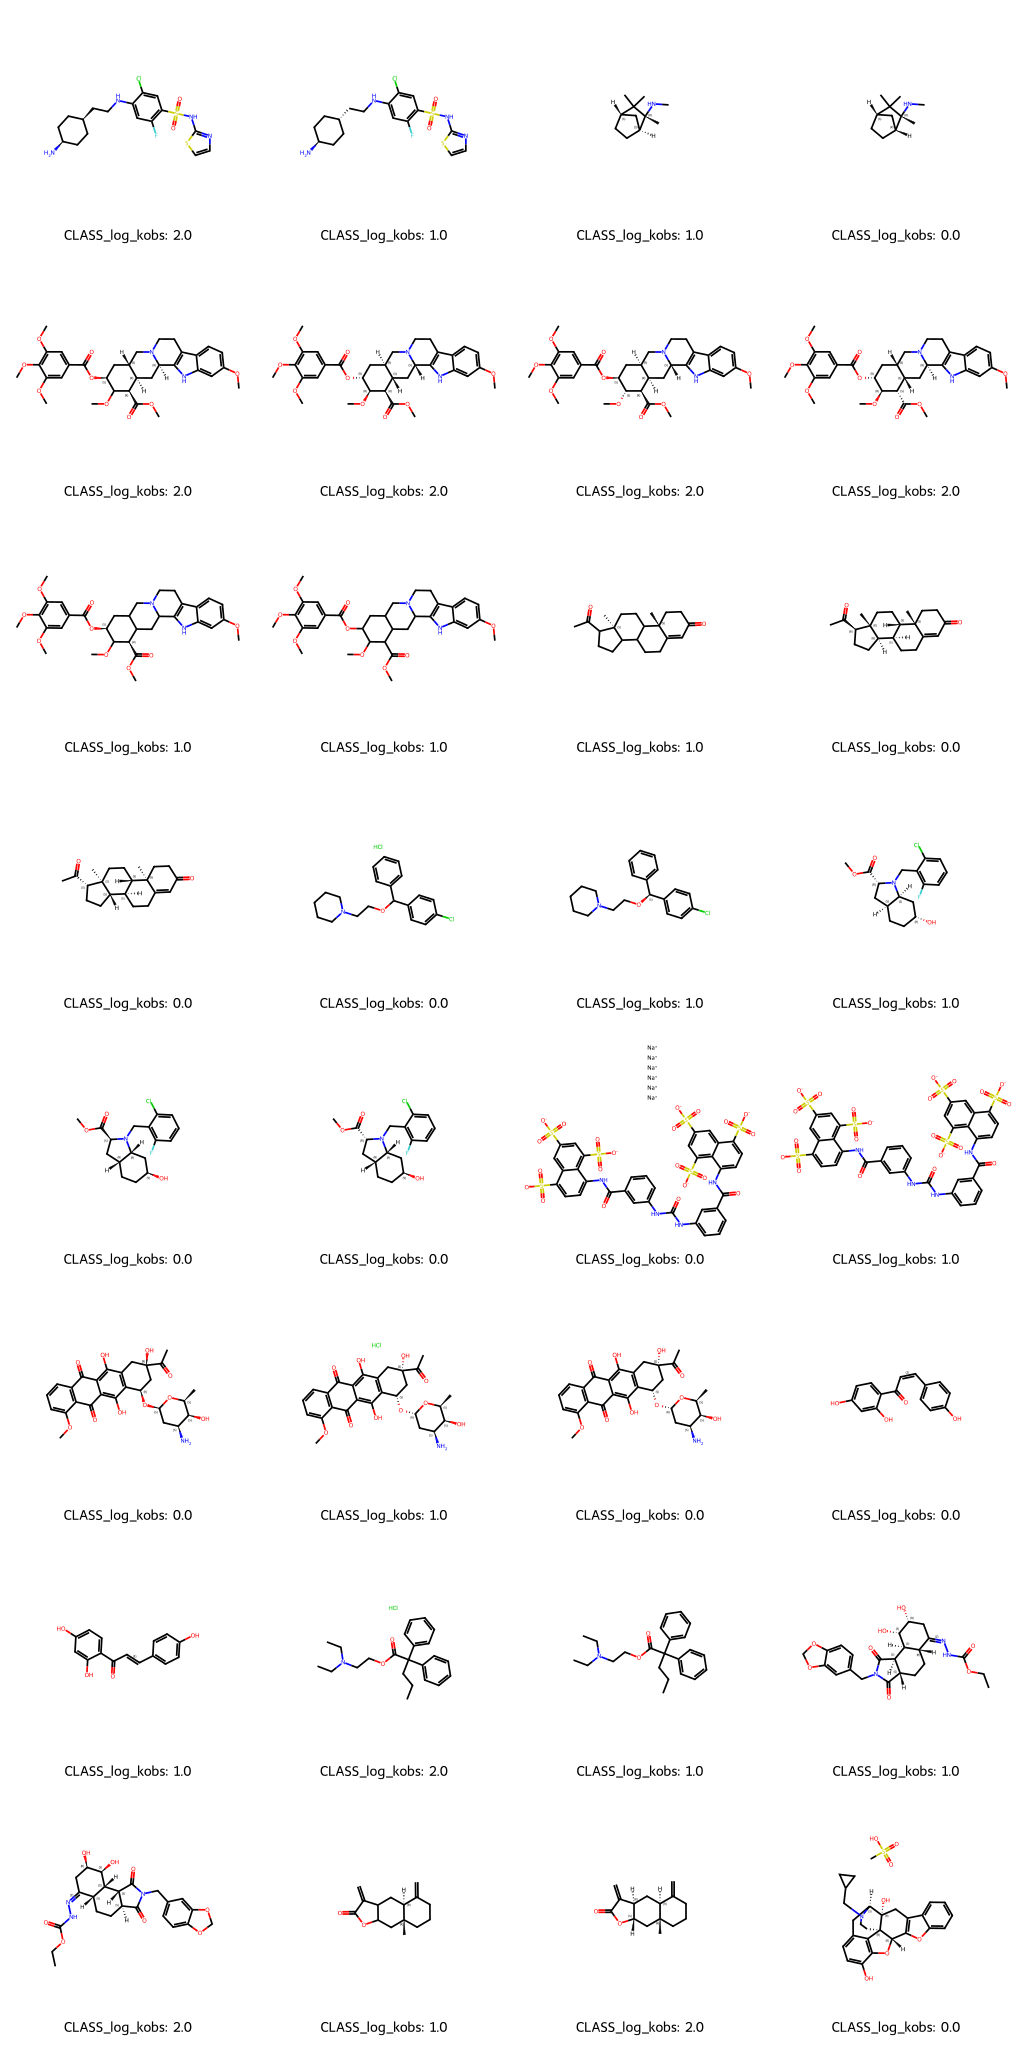

In [58]:
figs = verify_stereoisomers(
    data_cols=["CLASS_log_kobs"],
    dataset=data_look,
    mol_col=mol_col
)
figs[0]

1. Not all the salts were removed
2. many ambiguous compounds still in the Dataset
3. Stereoisomers in different activity classes.

In [54]:
data_look[["CLASS_log_kobs"]].value_counts()

CLASS_log_kobs
0.0               8126
1.0               5638
2.0               2608
Name: count, dtype: int64

### Re-run curation, removing molecules as needed

In [12]:
### Re-run the curation steps, this time removing molecules with undefined stereoisomers and removing duplicates
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    # remove molecules that have undefined stereocenters and also show activity shift to the stereoisomers
    mask_stereo_undefined_mols=False,
    # remove all the molecule rows including the duplicates
    keep_all_rows=False,
)

print(f"size before curation: {len(data)}")
data_curated = curator_with_stereo()
print(f"size after curation: {len(data_curated)}")

size before curation: 4200


2024-04-16 09:30:54.577 | WARNING  | polaris.curation._data_curator:run_data_curation:233 - Data types are not provides. We will try our best to determine the types
2024-04-16 09:30:54.579 | WARNING  | polaris.curation._data_curator:check_outliers:201 - Detected 3 outliers for data column LOGD_74 using zscore. Please revise the data and consider remove the outliers. 


size after curation: 4198


/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True


In [14]:
# Additional meta-data on the column level
annotations = {
    "smiles": ColumnAnnotation(
        description="Molecule SMILES string", modality="molecule"
    ),
    "LOGD_74": ColumnAnnotation(
        description="Octan-1-ol/water (pH7.4) distribution coefficent.",
        user_attributes={
            "PH": "7.4",
        },
    ),
}

In [19]:
dataset = Dataset(
    # The table is the core data-structure required to construct a dataset
    table=data_curated[annotations.keys()],
    # Additional meta-data on the dataset level.
    name="AstraZeneca_LogD_74",
    description="Octan-1-ol/water (pH7.4) distribution coefficent experiment data released by AstraZeneca",
    source="https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301363/",
    annotations=annotations,
    tags=["ADME"],
    owner=HubOwner(user_id="Polaris", slug="polaris"),
    license="CC-BY-SA-4.0",
    user_attributes={"year": "2016"},
    curation_reference="https://github.com/polaris-hub/polaris-recipes/06_AstraZeneca/06_01_AZ_LogD_data_curation.ipynb",
)

In [20]:
# Make a temporary directory to save the dataset
temp_dir = tempfile.TemporaryDirectory().name

save_dir = dm.fs.join(temp_dir, "dataset")

path = dataset.to_json(save_dir)

# Look at the save destination
fs = dm.fs.get_mapper(save_dir).fs
fs.ls(save_dir)

['/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/tmpzhhql4ps/dataset/table.parquet',
 '/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/tmpzhhql4ps/dataset/dataset.json']

In [21]:
folder = "06_AstraZeneca"
data_curated.to_parquet(
    f"gs://polaris-private/curated_datasets/{folder}/{dataset.name}_curated.parquet"
)  # Save just in case. Requires a data folder.

save_dir = f"gs://polaris-private/Datasets/{folder}/{dataset.name}"
dataset.to_json(save_dir)

save_dir = f"gs://polaris-public/Datasets/{folder}/{dataset.name}"
dataset.to_json(save_dir)

# dataset.upload_to_hub()

'gs://polaris-public/Datasets/06_AstraZeneca/AstraZeneca_LogD_74/dataset.json'

In [22]:
d = Dataset.from_json('gs://polaris-public/Datasets/06_AstraZeneca/AstraZeneca_LogD_74/dataset.json')
d.license =  {"id": "CC-BY-4.0", "reference": "https://creativecommons.org/licenses/by/4.0/"}
d.upload_to_hub()